In [35]:
import networkx as nx
import matplotlib.pyplot as plt

In [32]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import ast

In [6]:
import CleanTweets as ct

[nltk_data] Downloading package stopwords to /Users/Lono/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Lono/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [42]:
from nltk import bigrams
import itertools
import collections

In [7]:
african_names = pd.read_csv("africa_names.csv", names = ["names", "nan"])

In [76]:
def get_wordcloud(df, text_col, title):# Generate a word cloud image
    wordcloud = WordCloud(background_color="white", width=1500, height=800).generate(' '.join(df[text_col]))

    # Display the generated image:

    plt.figure(figsize=(18,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('artefacts/' + title +'.eps', format='eps')

In [38]:
def draw_network(df, text_col, max_similarity, name):
    
    cv = CountVectorizer(ngram_range=(1,1), stop_words = 'english') # You can define your own parameters
    X = cv.fit_transform(df[text_col])
    Xc = (X.T * X) # Cosine similarity of words

    names = cv.get_feature_names() # This are the entity names (i.e. keywords)
    df_co = pd.DataFrame(data = Xc.toarray(), columns = names, index = names)

    a = df_co.stack().reset_index()
    a.columns = ['source', 'target','value']
    a_filtered=a.loc[ (a['value'] > max_similarity) & (a['source'] != a['target']) ]


    # Build your graph
    plt.figure(figsize=(20,10))
    G=nx.from_pandas_edgelist(a_filtered, 'source', 'target')

    # Plot the network:
    # pos = graphviz_layout(G)
    nx.draw(G, with_labels=True, node_color='orange', node_size=50, edge_color='green', linewidths=2, font_size=15)
    plt.savefig('artefacts/' + name +'.eps', format='eps')

In [37]:
# https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-bigrams/
def draw_cooccur_network(df, top_n_bigrams, col, title):
    terms_bigram = [list(bigrams(doc.split())) for doc in df[col]]
    bigramsls = list(itertools.chain(*terms_bigram))
    bigram_counts = collections.Counter(bigramsls)
    bigram_df = pd.DataFrame(bigram_counts.most_common(top_n_bigrams),
                                 columns=['bigram', 'count'])
    d = bigram_df.set_index('bigram').T.to_dict('records')

    # Create network plot 
    G = nx.Graph()

    # Create connections between nodes
    for k, v in d[0].items():
        G.add_edge(k[0], k[1], weight=(v * 10))

    fig, ax = plt.subplots(figsize=(15, 8))
    pos = nx.spring_layout(G, k=2)

    # Plot networks
    nx.draw_networkx(G, pos,
                     font_size=12,
                     width=3,
                     edge_color='grey',
                     node_color='purple',
                     with_labels = False,
                     ax=ax)

    # Create offset labels
    for key, value in pos.items():
        x, y = value[0]+.045, value[1]+.045
        ax.text(x, y,
                s=key,
                bbox=dict(facecolor='red', alpha=0.2),
                horizontalalignment='center', fontsize=13)
    plt.title(title)
    plt.savefig('artefacts/' + title +'.eps', format='eps')
    plt.show()

# Publications

## 1. Time/volume - line chart

In [11]:
df = pd.read_csv('data/bb_pulications.csv', index_col=0)

In [12]:
df['pub_year'] = df['bib'].apply(lambda x: ast.literal_eval(x)['pub_year'])
df_not_nan = df[df['pub_year']!= 'NA']

Note we lose a couple of publications because a number of them do not have publication year attached

In [13]:
#df_not_nan['pub_year'] = pd.to_datetime(df_not_nan['pub_year'])
df_not_nan['pub_year'] = df_not_nan['pub_year'].astype(int)
df_groupedby_date = df_not_nan.groupby('pub_year').count()
df_groupedby_date.reset_index(inplace=True)

/Users/Lono/miniconda3/envs/ethnicenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
df_groupedby_date['count'] = df_groupedby_date['container_type']

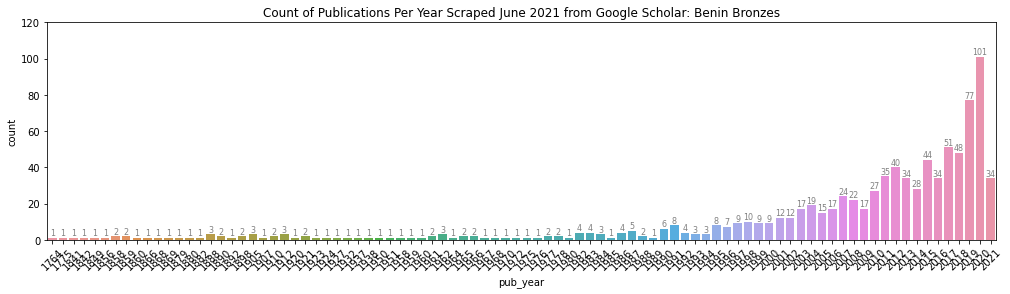

In [18]:
plt.figure(figsize=[17,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Year Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=df_groupedby_date, 
             x="pub_year", 
             y="count") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,120) #To make space for the annotations
plt.savefig('artefacts/bb_gs_pubcount.eps', format='eps')

In [20]:
df_groupedby_date_2016 = df_groupedby_date[df_groupedby_date['pub_year'] > 2015]

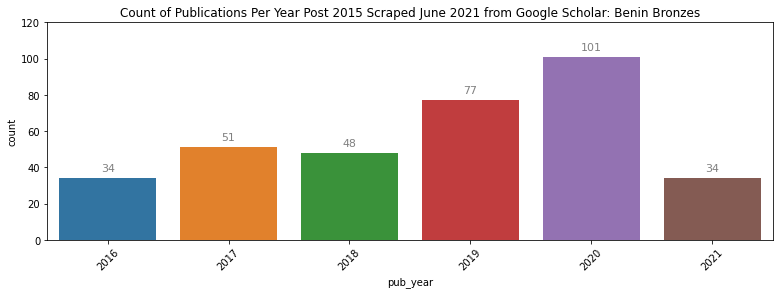

In [21]:
plt.figure(figsize=[13,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Year Post 2015 Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=df_groupedby_date_2016, 
             x="pub_year", 
             y="count")
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 10),
                textcoords='offset points')
_ = ax.set_ylim(0,120) #To make space for the annotations
plt.savefig('artefacts/bb_gs_pubcountpost2015.eps', format='eps')

## 2. Keywords - Network diagram

In [22]:
def get_abstract(x):
    try:
        return ast.literal_eval(x)['abstract']
    except KeyError:
        return ''

In [23]:
df['abstract'] = df['bib'].apply(lambda x: get_abstract(x) )
df_abs = df[df['abstract']!= '']

We lose around 100 publications because they do not have abstracts

In [24]:
df_abs = ct.clean_tweets(df_abs,'abstract','lemma_text',
                general_clean=True,lemma=True,stem=False,remove_tag=False,remove_mention=False,
                remove_emoji=False, remove_stopword=True,min_length=1, untokenized_return=True)

time taken to clean tweets: 7.975234031677246s. Use the [lemma_text] column to perform your analysis/modeling on


In [25]:
df_abs = ct.clean_tweets(df_abs,'abstract','stem_text',
                general_clean=True,lemma=False,stem=True,remove_tag=False,remove_mention=False,
                remove_emoji=False, remove_stopword=True,min_length=1, untokenized_return=True)

time taken to clean tweets: 1.1775290966033936s. Use the [stem_text] column to perform your analysis/modeling on


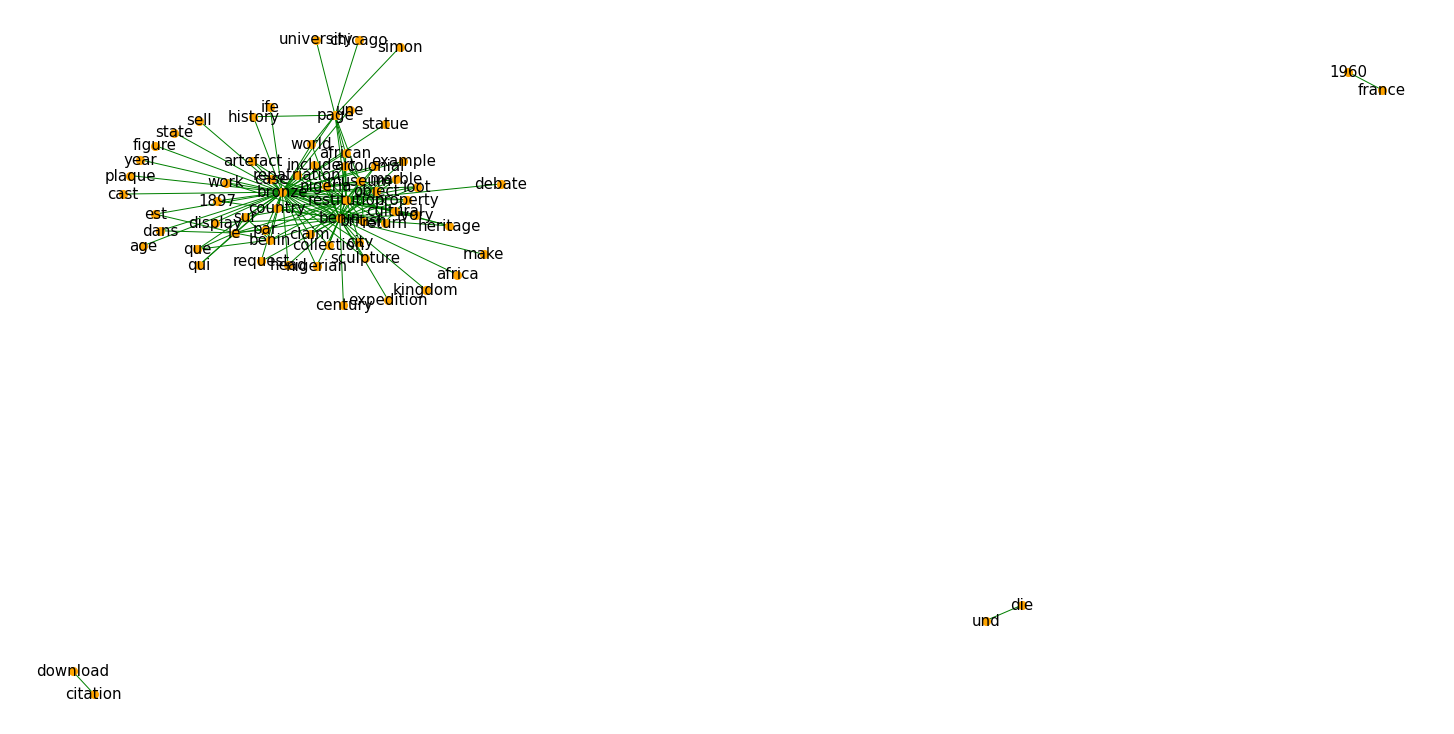

In [39]:
draw_network(df_abs, 'lemma_text', 30, 'bb_abstracts_30') 

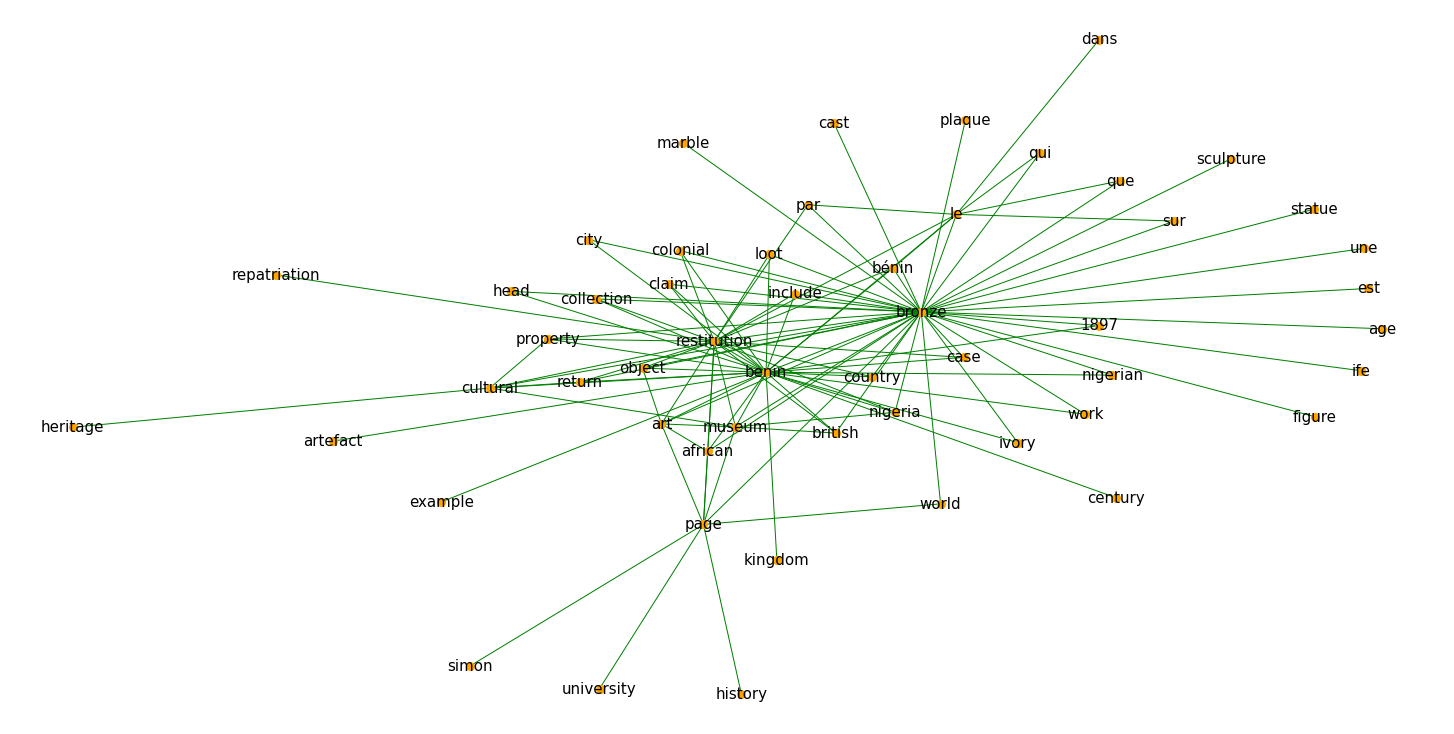

In [40]:
draw_network(df_abs, 'lemma_text', 35, 'bb_abstracts_35') 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

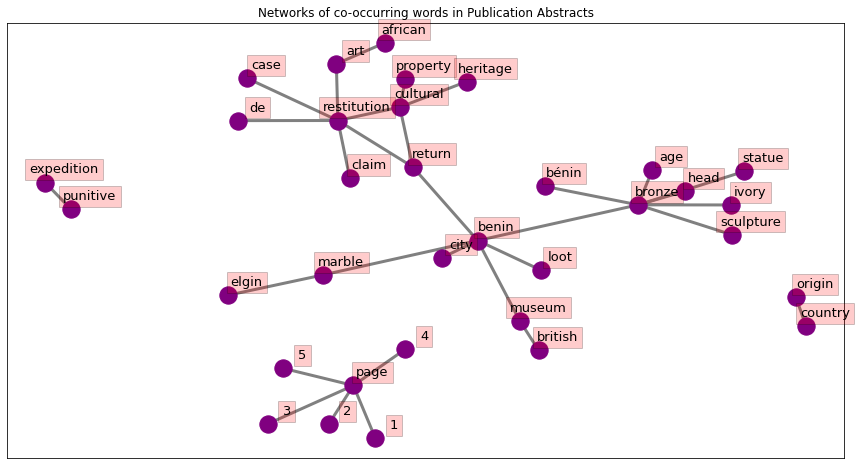

In [43]:
draw_cooccur_network(df_abs, 35,'lemma_text', 'Networks of co-occurring words in Publication Abstracts')

## 3. Peoples vs citations vs ethnicity - CSV list, network diagram

In [44]:
from ethnicolr import pred_wiki_ln, pred_wiki_name

Using TensorFlow backend.


In [45]:
import unicodedata

In [46]:
def clean_name(name, surname=False):
    if surname == True:
        res = name.split(' ')[1:]
        surname = ' '.join(chars for chars in res)
        if surname == '':
            surname = name.split(' ')[0]
        name = surname
            
    name = name.lower()
    #remove phonetics
    name = ''.join((c for c in unicodedata.normalize('NFD', name) if unicodedata.category(c) != 'Mn'))
    return name

### Authors African vs Not

In [47]:
df = pd.read_csv('data/bb_pulications.csv', index_col=0)

In [48]:
df.shape

(995, 13)

In [49]:
df['author'] = df['bib'].apply(lambda x: ast.literal_eval(x)['author'])

In [50]:
df['count'] = 1
dummy = df[['author', 'count']]
dummy1 = dummy.set_index('count').author.apply(pd.Series).stack().reset_index(level=0).rename(columns={0:'author'})

In [51]:
dummy1['author'] = dummy1['author'].apply(lambda x: clean_name(x) )

In [52]:
res = dummy1.groupby('author').agg('sum').reset_index().sort_values('count',ascending=False)
res['surname'] = res['author'].apply(lambda x: clean_name(x, True))

In [53]:
preds = pred_wiki_ln(res, "surname")
preds['african'] = preds['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [54]:
fix_list = african_names["names"].to_list()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


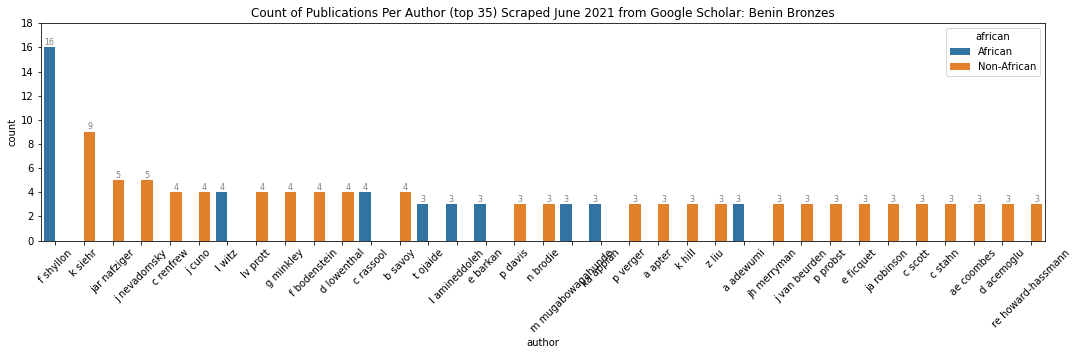

In [56]:
#manual fixes
#fix_list = ['ojaide', 'thebele', 'shyllon', 'sarr']
for name in fix_list:
    preds.loc[preds['surname']==name, 'african'] = 'African'
    
plt.figure(figsize=[18,4])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Author (top 35) Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=preds[0:35], 
             x="author", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,18) #To make space for the annotations
plt.savefig('bb_gs_pubsperauthor.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


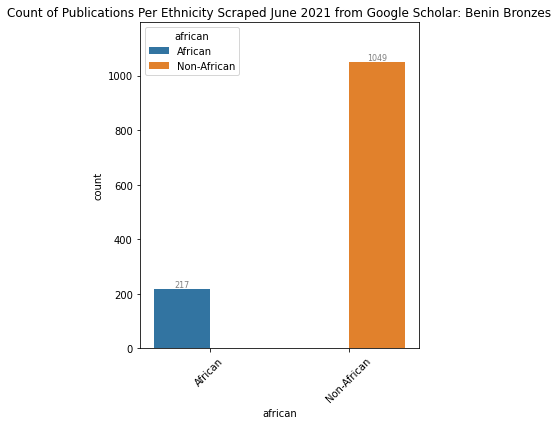

In [58]:
ratio = preds.groupby('african').agg('sum').reset_index()
plt.figure(figsize=[5,6])
plt.xticks(rotation=45)
plt.title('Count of Publications Per Ethnicity Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=ratio, 
             x="african", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,1195) #To make space for the annotations
plt.savefig('bb_gs_pubsperethnicity.eps', format='eps')

### Authors vs citations

These are the publications that have citations and only from 2016. A whole lot less publications from the total collected

In [59]:
df = pd.read_csv('data/bb_pub_citations.csv', index_col=0)
df['author'] = df['bib'].apply(lambda x: ast.literal_eval(x)['author'])
df['citing_authors'] = df['citations'].apply(lambda x: [item['author'] for item in ast.literal_eval(x)])
dummy = df[['author', 'num_citations']]

In [60]:
dummy1 = dummy.set_index('num_citations').author.apply(pd.Series).stack().reset_index(level=0).rename(columns={0:'author'})
dummy1['author'] = dummy1['author'].apply(lambda x: clean_name(x) )

In [61]:
res = dummy1.groupby('author').agg('sum').reset_index().sort_values('num_citations',ascending=False)
res['surname'] = res['author'].apply(lambda x: clean_name(x, True))

In [62]:
#ethnicity thing needs a specific dev environment
#https://ethnicolr.readthedocs.io/ethnicolr.html
preds = pred_wiki_ln(res, "surname")
preds['african'] = preds['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))

In [63]:
#manual fixes
for name in fix_list:
    preds.loc[preds['surname']==name, 'african'] = 'African'

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


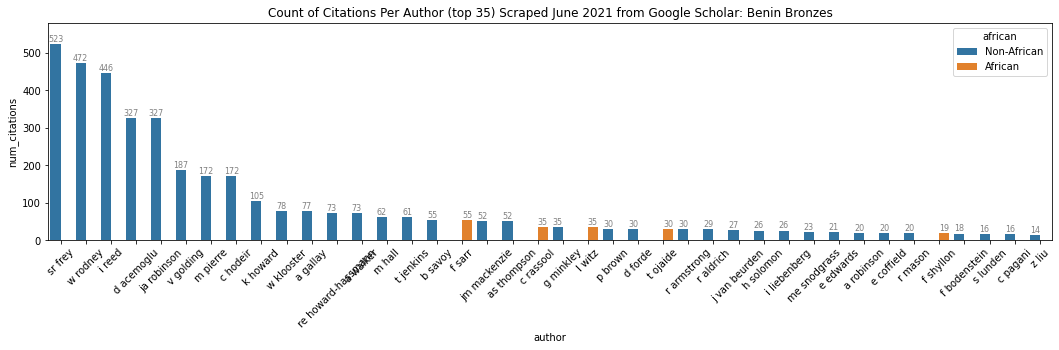

In [64]:
plt.figure(figsize=[18,4])
plt.xticks(rotation=45)
plt.title('Count of Citations Per Author (top 35) Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=preds[0:40], 
             x="author", 
             y="num_citations",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,580) #To make space for the annotations
plt.savefig('bb_gs_citesperauthor.eps', format='eps')

In [65]:
ratio = preds.groupby('african').agg('sum').reset_index()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


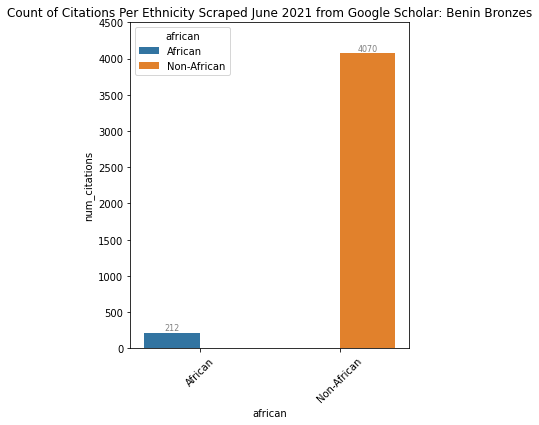

In [66]:
plt.figure(figsize=[5,6])
plt.xticks(rotation=45)
plt.title('Count of Citations Per Ethnicity Scraped June 2021 from Google Scholar: Benin Bronzes')
g = sns.barplot(data=ratio, 
             x="african", 
             y="num_citations",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,4500) #To make space for the annotations
plt.savefig('bb_gs_citesperethnicity.eps', format='eps')

### Citation Network graph

In [46]:
from collections import Counter
import nxviz as nv

In [ ]:
#note this requires the graph env
# also this is not working because I did not scrape enough sitations 
# for most of the publications that have above 20 citations

In [55]:
df = pd.read_csv('bb_pub_citations.csv', index_col=0)

In [71]:
print(df[df['num_citations']>20].shape)
df[df['num_citations']>20]

(24, 15)


,container_type,source,bib,filled,gsrank,pub_url,author_id,num_citations,url_scholarbib,url_add_sclib,citedby_url,url_related_articles,eprint_url,pub_year,citations
5,Publication,PublicationSource.PUBLICATION_SEARCH_SNIPPET,"{'title': 'The Dutch Moment: War, Trade, and S...",False,864,NaN,[''],78,/scholar?q=info:KWdYsRx0USEJ:scholar.google.co...,/citations?hl=en&xsrf=&continue=/scholar%3Fq%3...,"/scholar?cites=2400827742948452137&as_sdt=5,33...",/scholar?q=related:KWdYsRx0USEJ:scholar.google...,NaN,2016,[{'title': 'The apocalypse of settler colonial...
6,Publication,PublicationSource.PUBLICATION_SEARCH_SNIPPET,{'title': 'Peoples of the Niger-Benue Confluen...,False,875,https://books.google.com/books?hl=en&lr=&id=n8...,"['', '', '']",30,/scholar?q=info:YsCFPCwFdsIJ:scholar.google.co...,/citations?hl=en&xsrf=&continue=/scholar%3Fq%3...,"/scholar?cites=14012392978161975394&as_sdt=5,3...",/scholar?q=related:YsCFPCwFdsIJ:scholar.google...,NaN,2017,[{'title': 'Parties and politics in Northern N...
11,Publication,PublicationSource.PUBLICATION_SEARCH_SNIPPET,{'title': 'Water from the rock: Black resistan...,False,921,https://books.google.com/books?hl=en&lr=&id=UF...,[''],523,/scholar?q=info:Vx30KpF2BuYJ:scholar.google.co...,/citations?hl=en&xsrf=&continue=/scholar%3Fq%3...,"/scholar?cites=16575065844446666071&as_sdt=5,3...",/scholar?q=related:Vx30KpF2BuYJ:scholar.google...,NaN,2020,"[{'title': 'The churching of America, 1776-200..."
31,Publication,PublicationSource.PUBLICATION_SEARCH_SNIPPET,{'title': 'Keeping Their Marbles: How the Trea...,False,90,https://books.google.com/books?hl=en&lr=&id=TA...,[''],60,/scholar?q=info:Bv4VIEsaMQ0J:scholar.google.co...,/citations?hl=en&xsrf=&continue=/scholar%3Fq%3...,"/scholar?cites=950569906315066886&as_sdt=5,33&...",/scholar?q=related:Bv4VIEsaMQ0J:scholar.google...,NaN,2016,"[{'title': 'The archaeology of human bones', '..."
37,Publication,PublicationSource.PUBLICATION_SEARCH_SNIPPET,{'title': 'Treasures in trusted hands: negotia...,False,121,https://library.oapen.org/handle/20.500.12657/...,[''],26,/scholar?q=info:XOqfkp6ZujsJ:scholar.google.co...,/citations?hl=en&xsrf=&continue=/scholar%3Fq%3...,"/scholar?cites=4303921300249766492&as_sdt=5,33...",/scholar?q=related:XOqfkp6ZujsJ:scholar.google...,https://library.oapen.org/bitstream/handle/20....,2017,"[{'title': 'Radical empathy, the imaginary and..."
44,Publication,PublicationSource.PUBLICATION_SEARCH_SNIPPET,{'title': 'The colonial archival imaginaire at...,False,167,https://onlinelibrary.wiley.com/doi/abs/10.111...,[''],21,/scholar?q=info:u5Vh96po1RkJ:scholar.google.co...,/citations?hl=en&xsrf=&continue=/scholar%3Fq%3...,"/scholar?cites=1861509104491664827&as_sdt=5,33...",/scholar?q=related:u5Vh96po1RkJ:scholar.google...,https://www.academia.edu/download/50920336/Soc...,2016,[{'title': 'Archival encounters: rethinking ac...
48,Publication,PublicationSource.PUBLICATION_SEARCH_SNIPPET,{'title': 'Situational ethics and engaged prac...,False,188,https://www.taylorfrancis.com/chapters/edit/10...,[''],62,/scholar?q=info:XD_6ENMiSWIJ:scholar.google.co...,/citations?hl=en&xsrf=&continue=/scholar%3Fq%3...,"/scholar?cites=7082230178935095132&as_sdt=5,33...",/scholar?q=related:XD_6ENMiSWIJ:scholar.google...,NaN,2020,[{'title': 'Conflicting rationalities: Implica...
71,Publication,PublicationSource.PUBLICATION_SEARCH_SNIPPET,"{'title': 'Restituer le patrimoine africain', ...",False,349,NaN,"['', '']",52,/scholar?q=info:q3YtDEkk3rkJ:scholar.google.co...,/citations?hl=en&xsrf=&continue=/scholar%3Fq%3...,"/scholar?cites=13393182238001952427&as_sdt=5,3...",/scholar?q=related:q3YtDEkk3rkJ:scholar.google...,NaN,2018,[{'title': 'Transnational foreign cultural pol...
86,Publication,PublicationSource.PUBLICATION_SEARCH_SNIPPET,{'title': 'Learning at the museum frontiers: I...,False,425,https://books.google.com/books?hl=en&lr=&id=Ze...,[''],187,/scholar?q=info:bnSEZN73aNsJ:scholar.google.co...,/citations?hl=en&xsrf=&continue=/scholar%3Fq%3...,"/scholar?cites=1581

In [67]:
df['author'] = df['bib'].apply(lambda x: ast.literal_eval(x)['author'])
df['citing_authors'] = df['citations'].apply(lambda x: [item['author'] for item in ast.literal_eval(x)])

In [ ]:
df = df[['author', 'citing_authors']]
#need to explode twice to extract citation lists adequately
df = df.explode('author')
df = df.explode('citing_authors')
df = df.explode('citing_authors')

In [ ]:
df['count'] = 1

In [ ]:
authors_flat = [
    author
    for author in list(df["author"].dropna())
]

In [48]:
G = nx.from_pandas_edgelist(
    df, source="author", target="citing_authors", edge_attr="count"
)

# Limit to TOP 50 authors
top50authors = pd.DataFrame.from_records(
    Counter(authors_flat).most_common(50), columns=["author", "count"]
)

In [49]:
top50_nodes = (n for n in list(G.nodes()) if n in list(top50authors["author"]))

G_50 = G.subgraph(top50_nodes)

for n in G_50.nodes():
    G_50.nodes[n]["citations"] = int(
        top50authors[top50authors["author"] == n]["count"]
    )

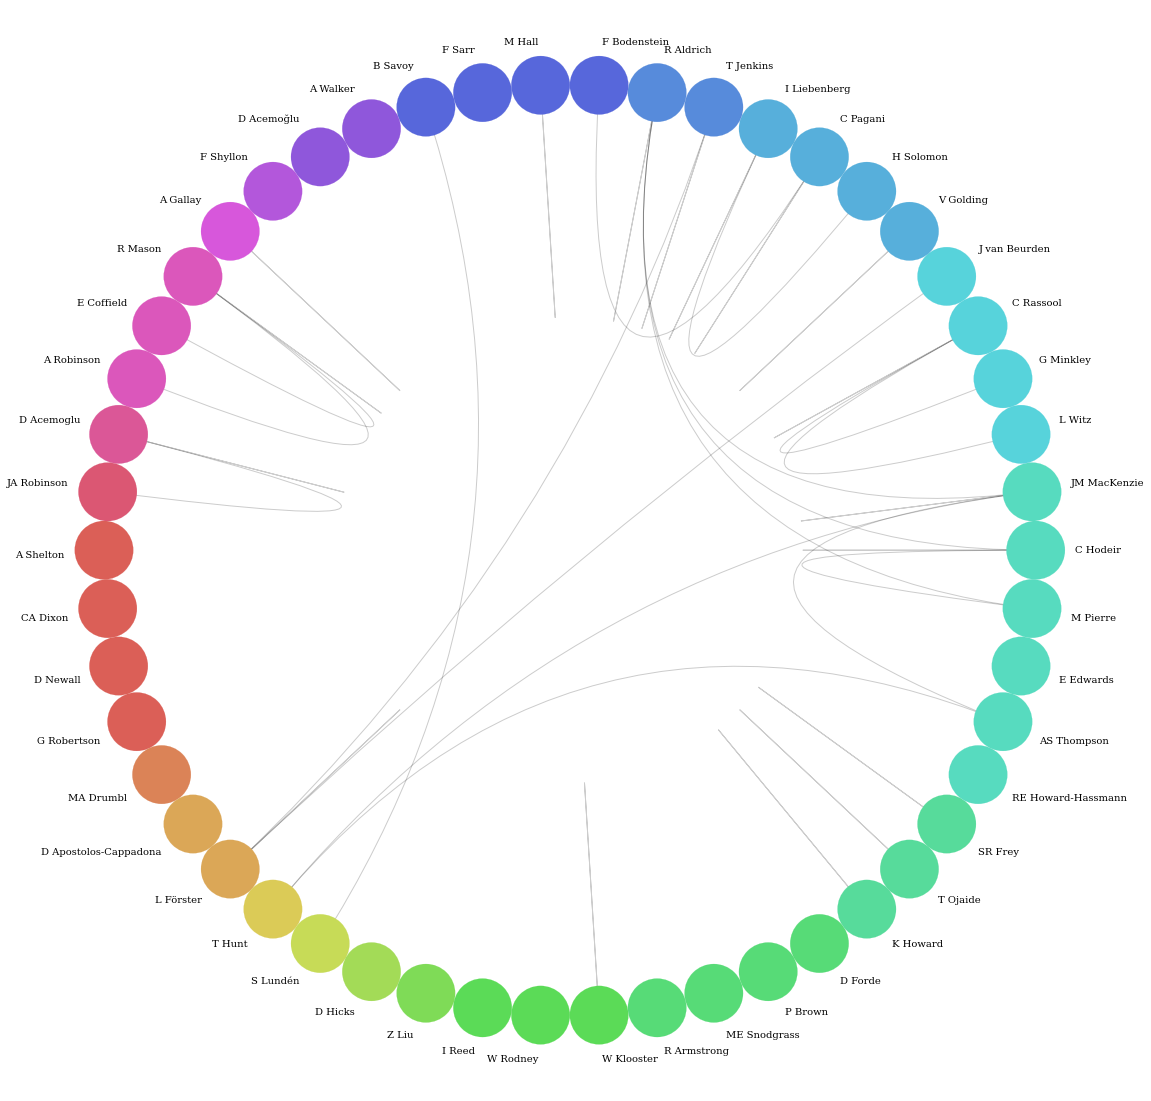

In [51]:
c = nv.CircosPlot(
    G_50,
    dpi=600,
    node_grouping="citations",
    edge_width="count",
    figsize=(20, 20),
    node_color="citations",
    node_labels=True,
)
c.draw()
plt.show()

# Media 

In [69]:
df = pd.read_csv('data/bb_google_content172_cleaned.csv', index_col=0)

### 1. Keywords - Network diagram: Pelonomi

The green newtork diagrams are with regards to word similarity based on the texts

In [70]:
print(df.shape)
df_text = df[~df['text'].isna()]
df_text.shape

(172, 7)


(164, 7)

So, we lost a couple of articles because we could not get text from them (their text is NaN)

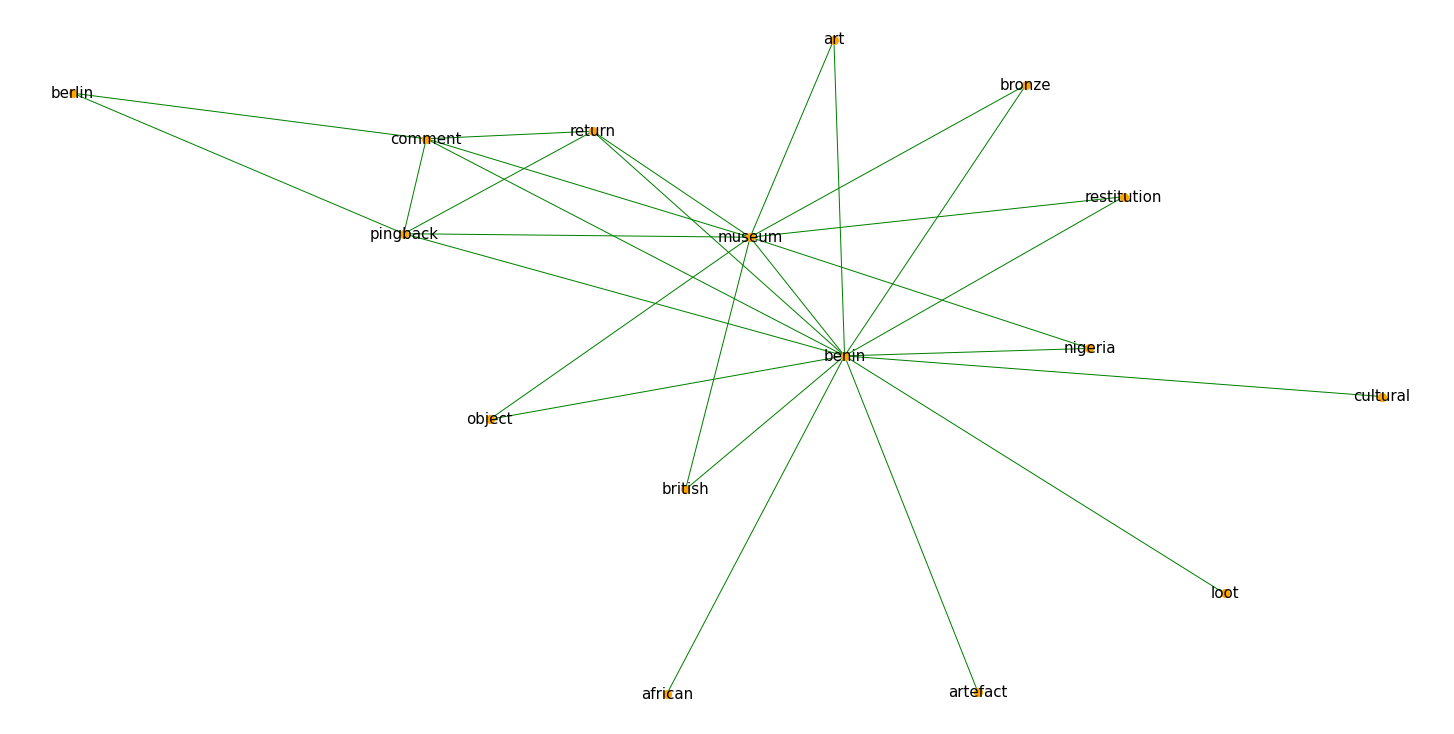

In [73]:
draw_network(df_text, 'lemma_text', 20000, 'bb_gc_content20000') #20000

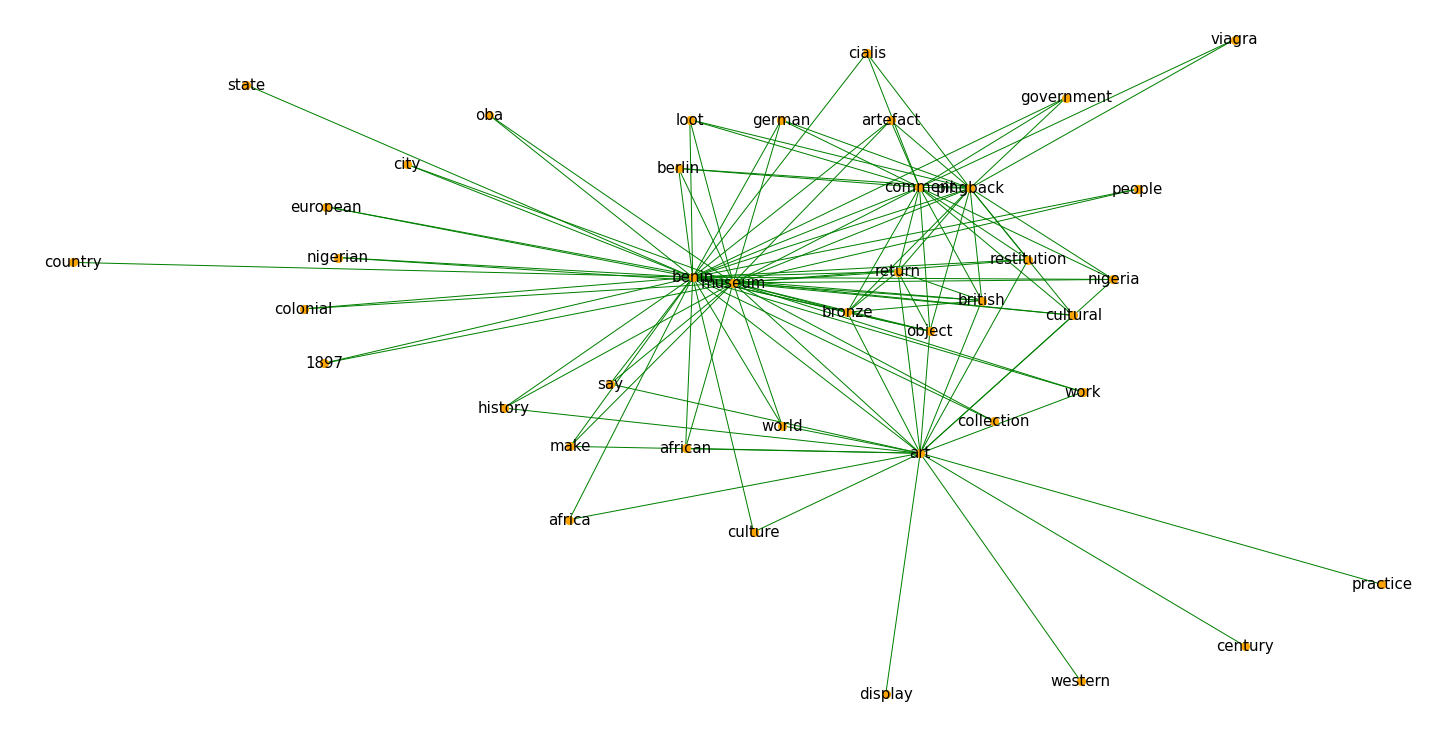

In [74]:
draw_network(df_text, 'lemma_text', 10000, 'bb_gc_content10000') #10000

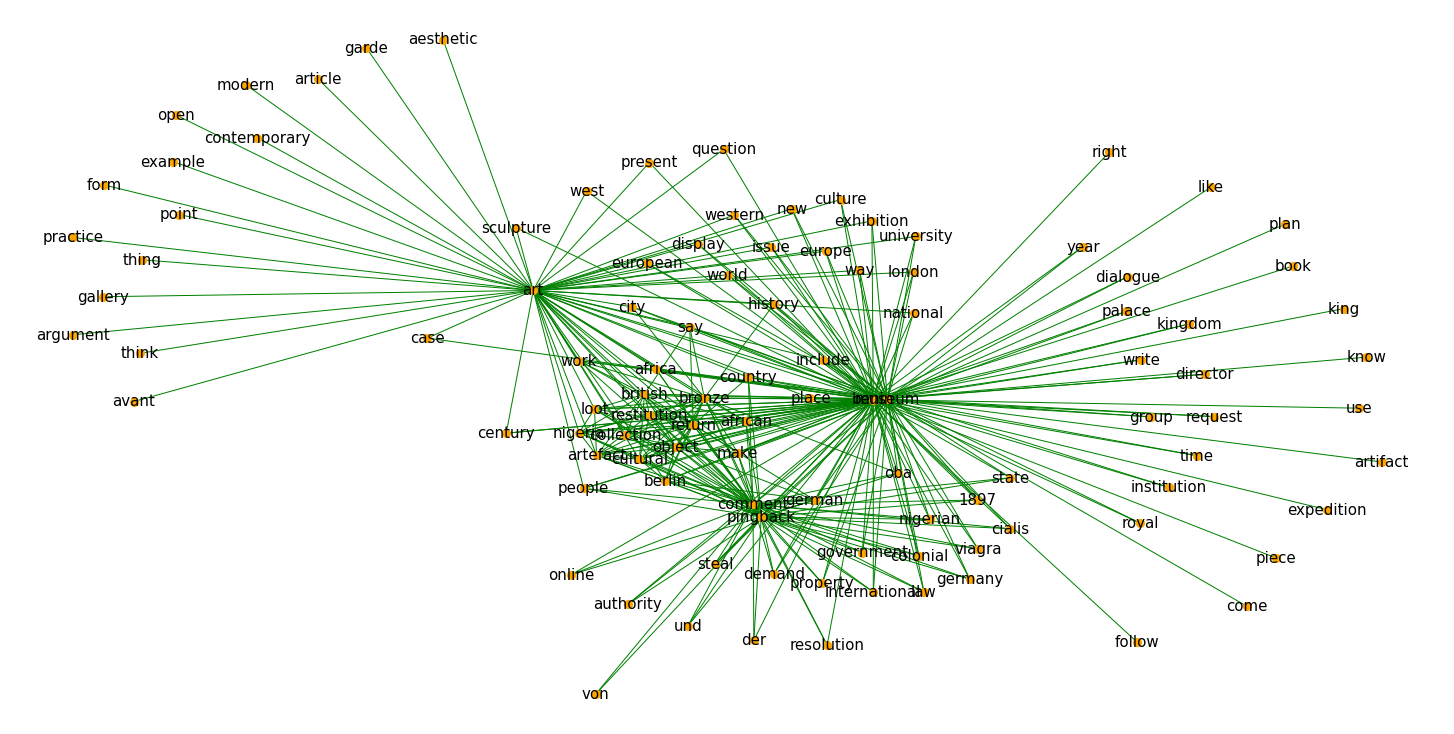

In [75]:
draw_network(df_text, 'lemma_text', 5000, 'bb_gc_content5000') #10000

In [77]:
df_not_nan = df[~df['lemma_text'].isna()]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

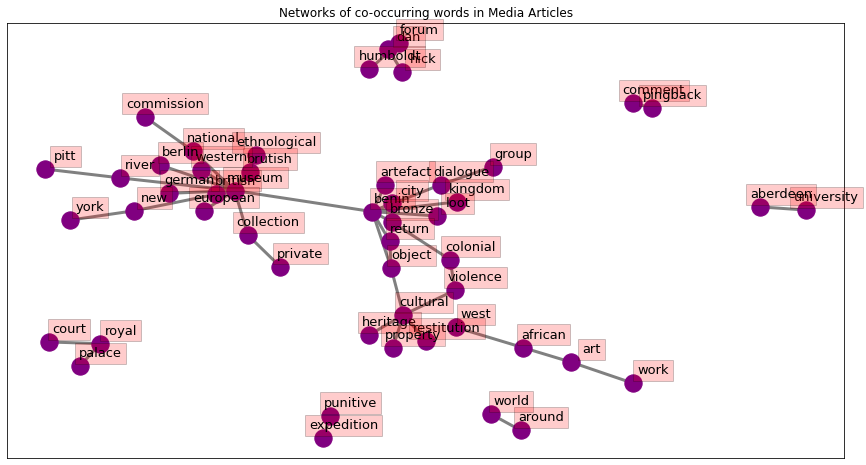

In [78]:
draw_cooccur_network(df_not_nan, 45,'lemma_text', 'Networks of co-occurring words in Media Articles')

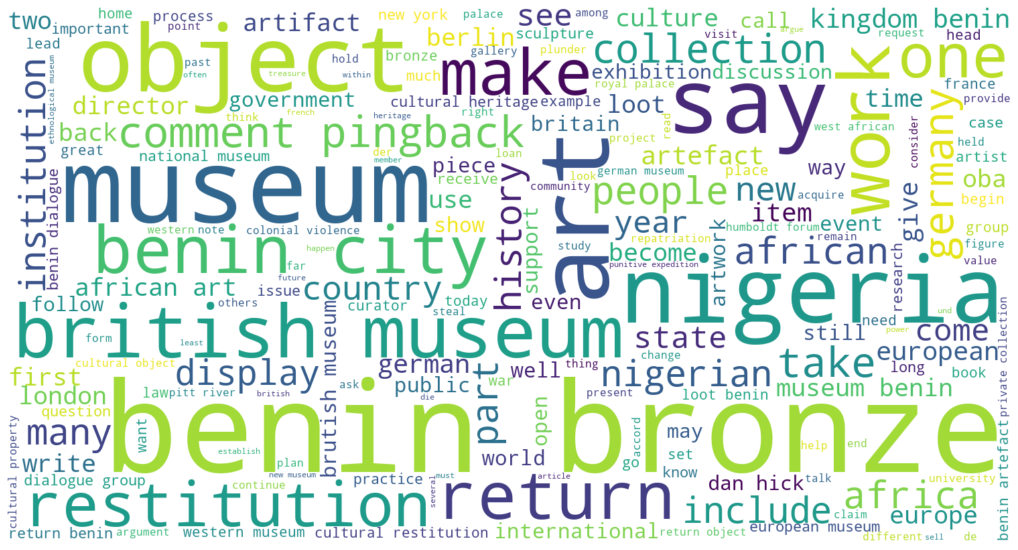

In [79]:
get_wordcloud(df_text, 'lemma_text', 'bb_content_wc')

### 2. Peoples vs mentions vs ethnicity - CSV list, bar chart: Pelonomi

In [ ]:
#this section requires Spacy
#!pip install spacy
#!python -m spacy download en_core_web_sm

#### Get names first

In [8]:
import spacy

In [51]:
from nltk.corpus import stopwords

In [4]:
def NER(text):
    """Takes in a string of text and returns a dataframe of all named entities
    
        Args:
            :param text: string, a string containing entire corpus
    """
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)

    entities = []
    labels = []
    position_start = []
    position_end = []

    for ent in doc.ents:
        entities.append(ent)
        labels.append(ent.label_)
        position_start.append(ent.start_char)
        position_end.append(ent.end_char)

    df = pd.DataFrame({'Entities':entities,'Labels':labels,'Position_Start':position_start, 'Position_End':position_end})

    return df

In [14]:
df.sample(10)

,title,link,text,date,html_date,lemma_text,stem_text
124,University Of Aberdeen And German Museums To R...,https://www.thevintagenews.com/2021/05/05/beni...,The Benin Bronzes is the name given to over a ...,NaN,2021-05-05,benin bronze name give thousand metal plaque s...,benin bronz name given thousand metal plaqu sc...
91,The Haunting History of the Benin Bronzes - Th...,https://artangle.libsyn.com/the-haunting-histo...,"Feb 25, 2021\nFor decades, one of the most urg...",NaN,2021-02-25,feb 25 2021 decade one urgent moral debate mus...,feb 25 2021 decad one urgent moral debat museu...
9,Germany Will Return Benin Bronzes to Nigeria i...,https://www.smithsonianmag.com/smart-news/majo...,SIGN UP for our newsletter\n“We face a histori...,2021-04-30,2021-04-30,sign newsletter we face historic moral respons...,sign newslett we face histor moral respons shi...
41,Are the Benin Bronzes On Their Way to Repatria...,https://www.widewalls.ch/magazine/benin-bronze...,African nations have long demanded the restitu...,NaN,2021-04-13,african nation long demand restitution poach c...,african nation long demand restitut poach cult...
105,"The Brutish Museums : The Benin Bronzes, Colon...",https://housmans.com/product/the-brutish-museu...,"Description\nby Hicks, Dan | The arts\nPublish...",NaN,2020-11-03,description hick dan art publish 20082020 plut...,descript hick dan art publish 20082020 pluto p...
58,"The Brutish Museums: the Benin Bronzes, Coloni...",https://www.kenyon.edu/events/the-brutish-muse...,"The Brutish Museums: the Benin Bronzes, Coloni...",NaN,2021-04-21,brutish museum benin bronze colonial violence ...,brutish museum benin bronz coloni violenc cult...
50,The Brutish Museums: The Benin Bronzes ... - A...,https://www.amazon.fr/Brutish-Museums-Colonial...,"The centre-piece, the prize exhibit of the boo...",NaN,2021-05-19,centre piece prize exhibit book capture city b...,centr piec prize exhibit book captur citi beni...
375,The Brutish Museums: The Benin Bronzes ... - A...,https://www.amazon.co.uk/Brutish-Museums-Colon...,"The centre-piece, the prize exhibit of the boo...",NaN,2021-03-12,centre piece prize exhibit book capture city b...,centr piec prize exhibit book captur citi beni...
95,"Germany to return Benin Bronzes, looted during...",https://thegrio.com/2021/05/02/germany-to-retu...,"Germany to return Benin Bronzes, looted during...",NaN,2021-05-02,germany return benin bronze loot colonial era ...,germani return benin bronz loot coloni era nig...
72,"The Brutish Museums: The Benin Bronzes, Coloni...",https://africa.berkeley.edu/brutish-museums-be...,NaN,NaN,NaN,NaN,NaN


In [148]:
#there is a couple of nans in here (8 articles in total) including two Japanese articles hahaha
df = df[~df['text'].isna()]
text = ''.join(x for x in df['text'])

In [149]:
#stopwords_eng = stopwords.words('english')
#tokenized_doc = text.split()
no_stopwords = " ".join([item for item in tokenized_doc if item not in stopwords_eng])  

In [150]:
ner_df = NER(text[0:1000000])
ner_df2 = NER(text[1000000:])

In [151]:
ner = pd.concat([ner_df, ner_df2])

In [153]:
ner['count'] = 1
ner.groupby('Entities').agg('sum').reset_index().sort_values('count',ascending=False)

,Entities,Position_Start,Position_End,count
0,"(Benin, Bronzes)",0,13,1
11520,(Stuttgart),653031,653040,1
11506,(German),652511,652517,1
11507,"(Heiko, Maas)",652535,652545,1
11508,(German),652682,652688,1
...,...,...,...,...
5762,"(Rutgers, University)",280117,280135,1
5763,(2009),280140,280144,1
5764,(EHSS),280175,280179,1
5765,(Paris),280181,280186,1


In [154]:
ner = ner[(ner['Labels'] == 'PERSON')]

In [155]:
ner['Entities'] = ner['Entities'].astype(str)
ner = ner.groupby('Entities').agg('sum').reset_index().sort_values('count',ascending=False)

In [156]:
exl_list = ['Benin', 'British', 'Museums', 'Benin Bronze', 'Benin Bronzes']
ner = ner[~ner['Entities'].isin(exl_list)]
ner.head(40)

,Entities,Position_Start,Position_End,count
237,Dan Hicks,29763012,29763633,69
886,Queen Victoria,9489217,9489539,23
318,Emmanuel Macron,12016735,12017050,21
290,Dunstone,1686090,1686258,21
251,David Adjaye,7089944,7090196,21
441,Heiko Maas,9128230,9128430,20
566,K. Opoku,11460469,11460605,17
807,Ogundele,7147452,7147580,16
679,Macron,8036348,8036438,15
89,Awoyemi,1218050,1218155,15


In [159]:
ner[['Entities', 'count']].to_csv('bb_media_people_mentions.csv')

I wrote to file here, started the ethnic env then read in the file and continued

In [80]:
ner = pd.read_csv('data/bb_media_people_mentions.csv', index_col=0)

In [81]:
ner

,Entities,count
237,Dan Hicks,69
886,Queen Victoria,23
318,Emmanuel Macron,21
290,Dunstone,21
251,David Adjaye,21
441,Heiko Maas,20
566,K. Opoku,17
807,Ogundele,16
679,Macron,15
89,Awoyemi,15


In [82]:
ner['surname'] = ner['Entities'].apply(lambda x: clean_name(x, True))

In [83]:
preds2 = pred_wiki_ln(ner, "surname")

In [84]:
preds2

,Entities,count,surname,race,"Asian,GreaterEastAsian,EastAsian","Asian,GreaterEastAsian,Japanese","Asian,IndianSubContinent","GreaterAfrican,Africans","GreaterAfrican,Muslim","GreaterEuropean,British","GreaterEuropean,EastEuropean","GreaterEuropean,Jewish","GreaterEuropean,WestEuropean,French","GreaterEuropean,WestEuropean,Germanic","GreaterEuropean,WestEuropean,Hispanic","GreaterEuropean,WestEuropean,Italian","GreaterEuropean,WestEuropean,Nordic"
237,Dan Hicks,69,hicks,"GreaterEuropean,British",0.003992,0.005343,0.003726,0.002907,0.001472,0.882301,0.002057,0.016326,0.040997,0.003739,0.027470,0.004902,4.766296e-03
886,Queen Victoria,23,victoria,"GreaterEuropean,WestEuropean,Italian",0.009047,0.023498,0.025983,0.004385,0.008857,0.136004,0.034582,0.023344,0.053404,0.006180,0.062053,0.611448,1.214440e-03
318,Emmanuel Macron,21,macron,"GreaterEuropean,British",0.023244,0.010613,0.002311,0.037240,0.004761,0.665650,0.005879,0.020877,0.173251,0.003579,0.009419,0.041029,2.147418e-03
290,Dunstone,21,dunstone,"GreaterEuropean,British",0.002814,0.000139,0.001628,0.000371,0.000827,0.903488,0.000461,0.011783,0.014347,0.002884,0.012439,0.043995,4.824538e-03
251,David Adjaye,21,adjaye,"GreaterAfrican,Africans",0.009281,0.000623,0.000972,0.627838,0.045743,0.140125,0.001231,0.015901,0.110195,0.013646,0.025981,0.002947,5.518856e-03
441,Heiko Maas,20,maas,"GreaterEuropean,WestEuropean,Germanic",0.000669,0.002996,0.010429,0.036995,0.016421,0.022806,0.048731,0.096347,0.050750,0.657533,0.016708,0.002931,3.668275e-02
566,K. Opoku,17,opoku,"GreaterEuropean,British",0.022633,0.039853,0.033959,0.334927,0.062218,0.340969,0.036262,0.039117,0.040456,0.003265,0.037853,0.007872,6.157563e-04
807,Ogundele,16,ogundele,"GreaterAfrican,Africans",0.003848,0.004103,0.000451,0.620314,0.002068,0.264233,0.001815,0.032758,0.010819,0.006018,0.037077,0.015091,1.404531e-03
679,Macron,15,macron,"GreaterEuropean,British",0.023244,0.010613,0.002311,0.037240,0.004761,0.665650,0.005879,0.020877,0.173251,0.003579,0.009419,0.041029,2.147418e-03
89,Awoyemi,15,awoyemi,"GreaterAfrican,Africans",0.000026,0.000046,0.000015,0.987338,0.009854,0.000942,0.000142,0.000169,0.001226,0.000006,0.000172,0.000058,6.150399e-06


In [85]:
ner.groupby('surname').agg('sum').reset_index().sort_values('count', ascending=False)

,surname,count
404,hicks,70
585,macron,37
715,opoku,26
1008,zimmerer,25
261,dunstone,24
966,walker,24
944,victoria,23
579,maas,21
20,adjaye,21
68,awoyemi,19


In [86]:
preds2['african'] = preds2['race'].apply(lambda x: 'African' if x=='GreaterAfrican,Africans' else ('African' if x== 'GreaterAfrican,Muslim' else 'Non-African'))

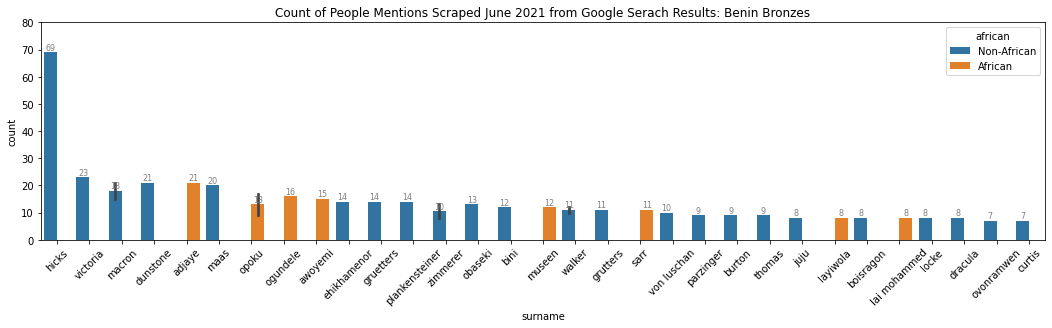

In [44]:
#manual fixes
for name in fix_list:
    preds2.loc[preds2['surname']==name, 'african'] = 'African'
    
plt.figure(figsize=[18,4])
plt.xticks(rotation=45)
plt.title('Count of People Mentions Scraped June 2021 from Google Serach Results: Benin Bronzes')
g = sns.barplot(data=preds2[0:35], 
             x="surname", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,80) #To make space for the annotations
plt.savefig('artefacts/' + title +'.eps', format='eps')

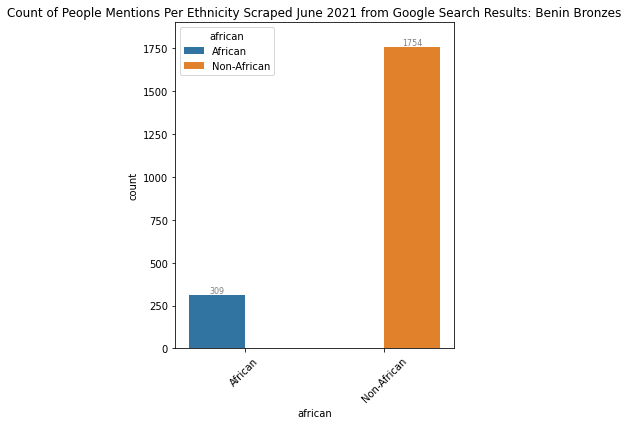

In [45]:
ratio = preds2.groupby('african').agg('sum').reset_index()
plt.figure(figsize=[5,6])
plt.xticks(rotation=45)
plt.title('Count of People Mentions Per Ethnicity Scraped June 2021 from Google Search Results: Benin Bronzes')
g = sns.barplot(data=ratio, 
             x="african", 
             y="count",
             hue="african") 
ax=g
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='gray', xytext=(0, 5),
                textcoords='offset points')
_ = ax.set_ylim(0,1900) #To make space for the annotations

TODO: need to fix this because there are some times where only the surname is mentioned, need to group by on that before getting the ethnicity to get a proper representation of the numbers